# import CS2SMOS

In [64]:
import os
import xarray as xr
from glob import glob

In [65]:
idir = '/scratch/project_465000269/edelleo1/Leo/SIT_observations/CS2SMOS/cs2smos_205/'
listfile = sorted(glob(os.path.join(idir,'*.nc')))  # get all files
list_files = listfile[:2]
nc = xr.open_mfdataset(list_files, combine='nested', concat_dim='time')

In [69]:
nc['analysis_sea_ice_thickness']

<xarray.DataArray 'analysis_sea_ice_thickness' (time: 2, yc: 432, xc: 432)>
dask.array<concatenate, shape=(2, 432, 432), dtype=float64, chunksize=(1, 432, 432), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2010-11-04T12:00:00 2010-11-05T12:00:00
  * xc       (xc) float32 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc       (yc) float32 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
    lon      (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
    lat      (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
Attributes:
    units:          m
    long_name:      CS2SMOS merged sea ice thickness
    standard_name:  sea_ice_thickness
    grid_mapping:   Lambert_Azimuthal_Grid

In [175]:
data_in = nc['analysis_sea_ice_thickness'][0].to_numpy()

In [81]:
data_dx = nc['analysis_sea_ice_thickness'].xc.to_numpy()
data_dy = nc['analysis_sea_ice_thickness'].yc.to_numpy()

In [87]:
# create meshgrid for data (CS2SMOS)
data_gx, data_gy = np.meshgrid(data_dx, data_dy)

In [164]:
d_grid = Grid(in_proj, data_gx*1000, data_gy*1000)

In [167]:
# define destination grid
d_grid.dst_grid = t_grid

In [176]:
# convert data
data_out = d_grid.convert(data_in)

In [11]:
import pyproj
from grid.grid import Grid
import numpy as np
from topaz.v4.confmap import ConformalMapping

In [103]:
cm = ConformalMapping.init_from_file('grid.info')

In [104]:
nx = cm._ires
ny = cm._jres

ii, jj = np.meshgrid(np.arange(nx), np.arange(ny))
lat, lon = cm.gind2ll(ii+1., jj+1.)

# ##find grid resolution
geod = pyproj.Geod(ellps='sphere')
_,_,dist_x = geod.inv(lon[:,1:], lat[:,1:], lon[:,:-1], lat[:,:-1])
_,_,dist_y = geod.inv(lon[1:,:], lat[1:,:], lon[:-1,:], lat[:-1,:])
dx = np.median(dist_x)
dy = np.median(dist_y)

##the coordinates in topaz model native grid
x = ii*dx
y = jj*dy

In [105]:
dx  # correct dx=13936.007..

13936.007011398644

In [8]:
##proj function that mimic what pyproj.Proj object does to convert x,y to lon,lat
def proj(x, y, inverse=False):
    if not inverse:
        i, j = cm.ll2gind(y, x)
        xo = (i-1)*dx
        yo = (j-1)*dy
    else:
        i = np.atleast_1d(x/dx + 1)
        j = np.atleast_1d(y/dy + 1)
        yo, xo = cm.gind2ll(i, j)
    if xo.size == 1:
        return xo.item(), yo.item()
    return xo, yo

# TOPAZ grid

In [106]:
t_grid = Grid(proj, x, y)

# CS2SMOS grid

All grids are projected onto the 25 km EASE2 Grid, which is based on a polar aspect spherical
Lambert azimuthal equal-area projection (Brodzik et al., 2012). The grid dimension is 5400 km
x 5400 km, equal to a 432 x 432 grid. The grid is centered on the geographic Pole, meaning
that the Pole is located at the intersection of center cells.
file:///home/leoede/Downloads/DT4-2_AWI_ESA_CS2SMOS_PDD_v1.5.pdf

In [134]:
in_proj = pyproj.Proj('+proj=laea +lon_0=0 +lat_0=90', inverse=True)

In [147]:
pyproj.Proj?

In [135]:
in_proj

<Other Coordinate Operation Transformer: laea>
Description: PROJ-based coordinate operation
Area of Use:
- undefined

In [131]:
in_proj(0,90)

(0.0, 0.0)

In [132]:
# x/y in data coordinates to lat/lon in meters
in_proj(30,80)

(557704.5254795029, -965972.5737415907)

In [133]:
# x/y in data coordinates to lat/lon in meters
in_proj(30,80, inverse=True)

(159.44395478041653, 89.99923505260686)

In [34]:
# from lat/lon to TOPAZ4b in meters
proj(159.44395478041653, 89.99923505260686)  # 0,90)

(669810.2551213239, -14261567.85664463)

In [36]:
Grid.convert?

# Plot

In [39]:
import matplotlib.pyplot as plt

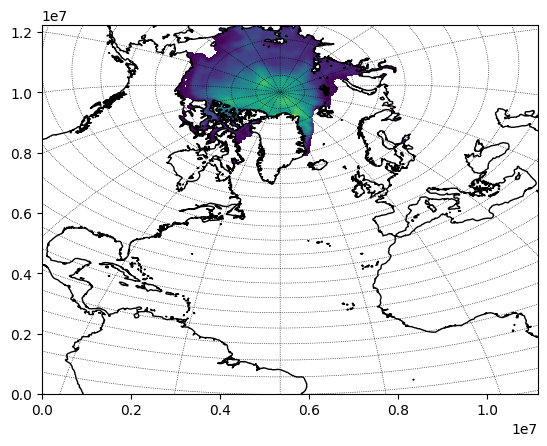

In [171]:
fig, ax = plt.subplots(1,1)
t_grid.plot_land(ax)
t_grid.plot_field(ax, data_out)

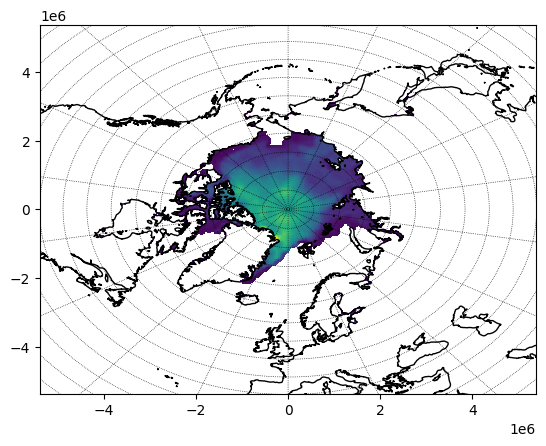

In [172]:
fig, ax = plt.subplots(1,1)
d_grid.plot_land(ax)
d_grid.plot_field(ax, data_in)